In [19]:
import time
import re

import numpy as np
import pandas as pd

# ML Models
import lightgbm as lgb
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import mean_absolute_error, r2_score, precision_recall_curve, confusion_matrix, classification_report
import shap
from dython.nominal import associations

# Hyperparameter Tuning
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import KFold, StratifiedKFold

# DataViz
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
from skopt.plots import plot_objective

# Progress Bar
from tqdm import tqdm

In [20]:
# matplotlib Color Setup

# Dracula Color Palette
COL_Background = '#272934'
COL_Selection = '#44475a'
COL_Foreground = '#f8f8f2'
COL_Comment = '#6272a4'
COL_Cyan = '#8be9fd'
COL_Green = '#50fa7b'
COL_Orange = '#ffb86c'
COL_Pink = '#ff79c6'
COL_Purple = '#bd93f9'
COL_Red = '#ff5555'
COL_Yellow = '#f1fa8c'

sequential_cmap = LinearSegmentedColormap.from_list(
    'custom_sequential', [COL_Comment, COL_Purple]
)

diverging_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging', [COL_Cyan, COL_Comment, COL_Purple]
)

categorical_cmap = ListedColormap(['#8be9fd', '#50fa7b', '#ffb86c', '#ff79c6', '#bd93f9', '#ff5555', '#f1fa8c'])

plt.rcParams.update({
    'figure.facecolor': COL_Background,
    'axes.facecolor': COL_Background,
    'axes.edgecolor': COL_Background,
    'axes.labelcolor': COL_Comment,
    'text.color': COL_Comment,
    'xtick.color': COL_Comment,
    'ytick.color': COL_Comment,
    'grid.color': COL_Selection
})

In [21]:
SEED = 1

In [22]:
df = pd.concat([pd.read_csv('DataSet/train.csv'), pd.read_csv('DataSet/test.csv')], sort=False, ignore_index=True)
print(f'Train Dataset Size {len(df.loc[df['Survived'].notna()])} rows\nTest Dataset Size {len(df.loc[df['Survived'].isna()])} rows')
df

Train Dataset Size 891 rows
Test Dataset Size 418 rows


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Feature Engineering

In [23]:
df['Survived'] = df['Survived'].astype('boolean')
numeric_features = []
categorical_features = ['Pclass', 'Sex', 'Embarked']
pd.DataFrame({'Number of NAs': df.isna().sum(), 'Dtypes': df.dtypes})

,Number of NAs,Dtypes
PassengerId,0,int64
Survived,418,boolean
Pclass,0,int64
Name,0,object
Sex,0,object
Age,263,float64
SibSp,0,int64
Parch,0,int64
Ticket,0,object
Fare,1,float64


In [24]:
# Name & Title
title_mappings = {
    'Noble': ['Lady', 'Countess', 'Dona', 'Jonkheer', 'Don', 'Sir'],
    'Military': ['Major', 'Col', 'Capt'],
    'Professional': ['Dr', 'Rev'],
    'Miss': ['Miss', 'Ms', 'Mlle'],
    'Mrs': ['Mrs', 'Mme'],
    'Master': ['Master'],
    'Mr' : ['Mr']
}
reverse_title_mappings = {t: cat for cat, ts in title_mappings.items() for t in ts}
df['Title'] = (
    df['Name']
    .str.extract(r',.*?\s([A-Za-z]+)\.', expand=False)
    .map(reverse_title_mappings)
)

df['NbNames'] = df['Name'].str.split().str.len().sub(1)

categorical_features += ['Title']
numeric_features += ['NbNames']

df[['Name', 'Title', 'NbNames']]

,Name,Title,NbNames
0,"Braund, Mr. Owen Harris",Mr,3
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,6
2,"Heikkinen, Miss. Laina",Miss,2
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,6
4,"Allen, Mr. William Henry",Mr,3
...,...,...,...
1304,"Spector, Mr. Woolf",Mr,2
1305,"Oliva y Ocana, Dona. Fermina",Noble,4
1306,"Saether, Mr. Simon Sivertsen",Mr,3
1307,"Ware, Mr. Frederick",Mr,2


In [25]:
# Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Traveling With
df['IsAlone'] = (df['FamilySize'] == 1)
df['WithSpouse'] = (~df['Title'].isin(['Miss', 'Master'])) & df['SibSp'] > 0
df['WithChildren'] = (~df['Title'].isin(['Miss', 'Master'])) & df['Parch'] > 0
df['WithParents'] = (df['Title'].isin(['Miss', 'Master'])) & df['Parch'] > 0

categorical_features += ['IsAlone', 'WithSpouse', 'WithChildren', 'WithParents']
numeric_features += ['FamilySize']

df.sort_values('Ticket')[['Name', 'SibSp', 'Parch', 'Title', 'Age', 'IsAlone', 'FamilySize', 'WithSpouse', 'WithChildren', 'WithParents']].loc[(df['SibSp'] > 0) | (df['Parch'] > 0)]

,Name,SibSp,Parch,Title,Age,IsAlone,FamilySize,WithSpouse,WithChildren,WithParents
585,"Taussig, Miss. Ruth",0,2,Miss,18.0,False,3,False,False,False
262,"Taussig, Mr. Emil",1,1,Mr,52.0,False,3,True,True,False
558,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,1,Mrs,39.0,False,3,True,True,False
366,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",1,0,Mrs,60.0,False,2,True,False,False
1127,"Warren, Mr. Frank Manley",1,0,Mr,64.0,False,2,True,False,False
...,...,...,...,...,...,...,...,...,...,...
86,"Ford, Mr. William Neal",1,3,Mr,16.0,False,5,True,True,False
905,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",1,0,Mrs,47.0,False,2,True,False,False
92,"Chaffee, Mr. Herbert Fuller",1,0,Mr,46.0,False,2,True,False,False
540,"Crosby, Miss. Harriet R",0,2,Miss,36.0,False,3,False,False,False


In [26]:
# Deck and Cabin
deck_letters = df['Cabin'].str[0]
deck_mappings = {
    'A' : 'A', 'B' : 'B', 'C' : 'C',
    'D' : 'D', 'E' : 'E',
    'F' : 'Lower', 'G' : 'Lower', 'T' : 'Lower'
}

df['DeckLevel'] = deck_letters.map(deck_mappings)

df['CabinNumber'] = (
    df['Cabin']
    .fillna('')
    .str.findall(r'(\d+)')
    .apply(lambda x: np.median([int(n) for n in x]) if x else pd.NA)
    .astype('Int64')
)
df['CabinLocation'] = pd.cut(
    df['CabinNumber'],
    bins=[0, 50, 100, float('inf')],
    labels=['Forward', 'Midship', 'Aft'],
    right=False
)

categorical_features += ['DeckLevel', 'CabinLocation']

df[['Cabin', 'DeckLevel', 'CabinLocation']].dropna(subset=['Cabin'])

,Cabin,DeckLevel,CabinLocation
1,C85,C,Midship
3,C123,C,Aft
6,E46,E,Forward
10,G6,Lower,Forward
11,C103,C,Aft
...,...,...,...
1295,D40,D,Forward
1296,D38,D,Forward
1298,C80,C,Midship
1302,C78,C,Midship


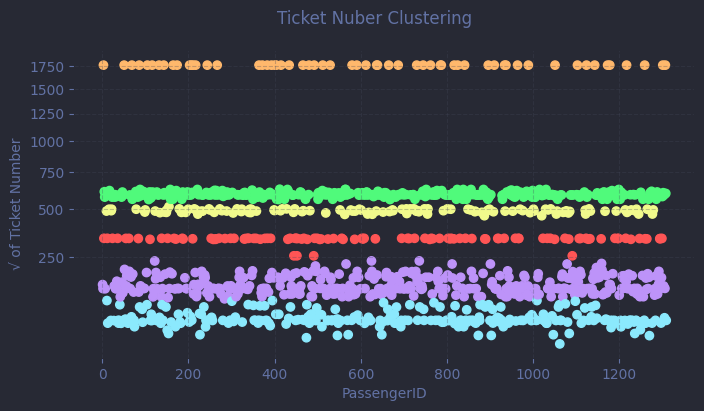

In [27]:
# Ticket Prefix/Cluster
df['TicketHasPrefix'] = ~df['Ticket'].str.isdigit()
df['Ticket'] = (
    df['Ticket']
    .str.extract(r'^.*?(\d*)$')
    .replace('', '0')
    .astype('Int64')
)

cluster = KMeans(n_clusters=6, random_state=SEED).fit(pd.DataFrame(df['Ticket'].pow(1/2)))
df['TicketCluster'] = cluster.labels_

fig = plt.figure(figsize=(8, 4))
ax = plt.gca()
plt.scatter([i + 1 for i in range(len(df['Ticket']))], df['Ticket'].pow(1/2), c=df['TicketCluster'], cmap=categorical_cmap)
ax.set_yscale(matplotlib.scale.FuncScale(ax, (lambda e: e**0.5, lambda e: e**2)))
plt.suptitle('Ticket Nuber Clustering')
plt.xlabel('PassengerID')
plt.ylabel('√ of Ticket Number')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('ticket_number_clustering.png')
plt.show()

categorical_features += ['TicketHasPrefix']
numeric_features += ['TicketCluster']

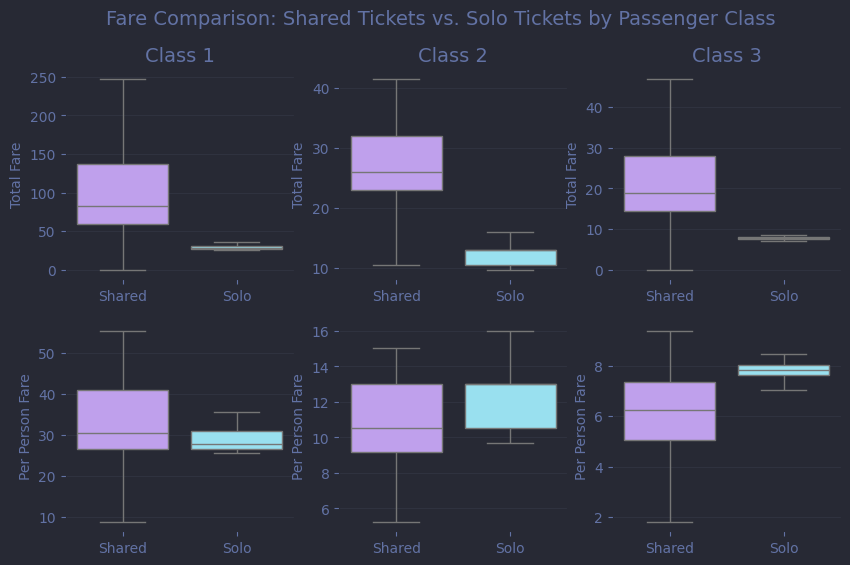

In [28]:
# PerPersonFare
df['GroupSize'] = df.groupby('Ticket')['Ticket'].transform('count')
df['TicketType'] = np.where(df['GroupSize'] > 1, 'Shared', 'Solo')
df['PerPersonFare'] = df['Fare'] / df['GroupSize']

numeric_features += ['PerPersonFare']

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Fare Comparison: Shared Tickets vs. Solo Tickets by Passenger Class', fontsize=14)

for i, pclass in enumerate([1, 2, 3]):
    class_data = df[df['Pclass'] == pclass]
    
    ax1 = axes[0, i]
    sns.boxplot(
        x='TicketType', y='Fare', data=class_data, 
        ax=ax1, showfliers=False, 
        order=['Shared', 'Solo'], 
        hue='TicketType', palette={'Shared' : COL_Purple, 'Solo' : COL_Cyan}
    )
    
    ax1.set_title(f'Class {pclass}', fontsize=14)
    ax1.set_xlabel('')
    ax1.set_ylabel('Total Fare')
    ax1.grid(axis='y', alpha=0.3)
    
    ax2 = axes[1, i]
    sns.boxplot(
        x='TicketType', y='PerPersonFare', data=class_data, 
        ax=ax2, showfliers=False, 
        order=['Shared', 'Solo'], 
        hue='TicketType', palette={'Shared' : COL_Purple, 'Solo' : COL_Cyan}
    )

    ax2.set_xlabel('')
    ax2.set_ylabel('Per Person Fare')
    ax2.grid(axis='y', alpha=0.3)

plt.savefig('fare_comparison.png')
plt.show()

In [29]:
# Group Survival Rate

overall_survival = df.loc[df['Survived'].notna(), 'Survived'].mean()
def calculate_group_survival(p_id, ticket):
    survival = []
    for p in df.itertuples():
        if p.Ticket == ticket:
            if pd.notna(p.Survived) and p.PassengerId != p_id:
                survival.append(p.Survived)
            else:
                survival.append(overall_survival)
    return np.average(survival)

# GroupSurvivalRate
df['GroupSurvivalRate'] = df.apply(lambda row: calculate_group_survival(row['PassengerId'], row['Ticket']), axis=1).astype('Float64')

numeric_features += ['GroupSurvivalRate']

df.sort_values('Ticket')[['Name', 'Ticket', 'Survived', 'GroupSurvivalRate']]

,Name,Ticket,Survived,GroupSurvivalRate
597,"Johnson, Mr. Alfred",0,False,0.34596
302,"Johnson, Mr. William Cahoone Jr",0,False,0.34596
271,"Tornquist, Mr. William Henry",0,True,0.09596
179,"Leonard, Mr. Lionel",0,False,0.34596
1077,"Phillips, Miss. Alice Frances Louisa",2,<NA>,0.383838
...,...,...,...,...
1300,"Peacock, Miss. Treasteall",3101315,<NA>,0.383838
1172,"Peacock, Master. Alfred Edward",3101315,<NA>,0.383838
1050,"Peacock, Mrs. Benjamin (Edith Nile)",3101315,<NA>,0.383838
511,"Webber, Mr. James",3101316,False,0.383838


In [30]:
# Age
age_features = ['Pclass', 'Sex', 'Fare', 'Embarked', 'Title', 'NbNames',
       'FamilySize', 'IsAlone', 'WithSpouse', 'WithChildren', 'WithParents',
       'DeckLevel', 'CabinLocation', 'TicketHasPrefix',
       'TicketCluster', 'GroupSize', 'PerPersonFare', 'GroupSurvivalRate'
]
age_df = df[age_features].copy()
for col in [f for f in age_features if f in categorical_features]:
    age_df[col] = age_df[col].astype('category')

age_train = age_df[df['Age'].notna()]
age_missing = age_df[df['Age'].isna()]
y_age = df.loc[df['Age'].notna(), 'Age']

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 96,
    'learning_rate': 0.1,
    'min_child_samples': 3,
    'seed': SEED,
    'verbosity': -1
}

cv_results = lgb.cv(
    params | {'num_iterations' : 50000, 'early_stopping_rounds' : 50},
    lgb.Dataset(age_train, label=y_age),
    nfold=5,
    stratified=False,
    seed=SEED
)

age_model = lgb.train(
    params | {'num_iterations' : len(cv_results['valid l1-mean'])},
    lgb.Dataset(age_train, label=y_age)
)

predicted_ages = age_model.predict(age_missing)
df.loc[df['Age'].isna(), 'Age'] = predicted_ages

df['IsChild'] = (
    (df['Title'] == 'Master') | 
    ((df['Title'] == 'Miss') & (df['Age'] < 18))
)

categorical_features += ['IsChild']
numeric_features += ['Age']

df[['IsChild', 'Age', 'Name']]

,IsChild,Age,Name
0,False,22.000000,"Braund, Mr. Owen Harris"
1,False,38.000000,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,False,26.000000,"Heikkinen, Miss. Laina"
3,False,35.000000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,False,35.000000,"Allen, Mr. William Henry"
...,...,...,...
1304,False,32.517529,"Spector, Mr. Woolf"
1305,False,39.000000,"Oliva y Ocana, Dona. Fermina"
1306,False,38.500000,"Saether, Mr. Simon Sivertsen"
1307,False,28.360047,"Ware, Mr. Frederick"


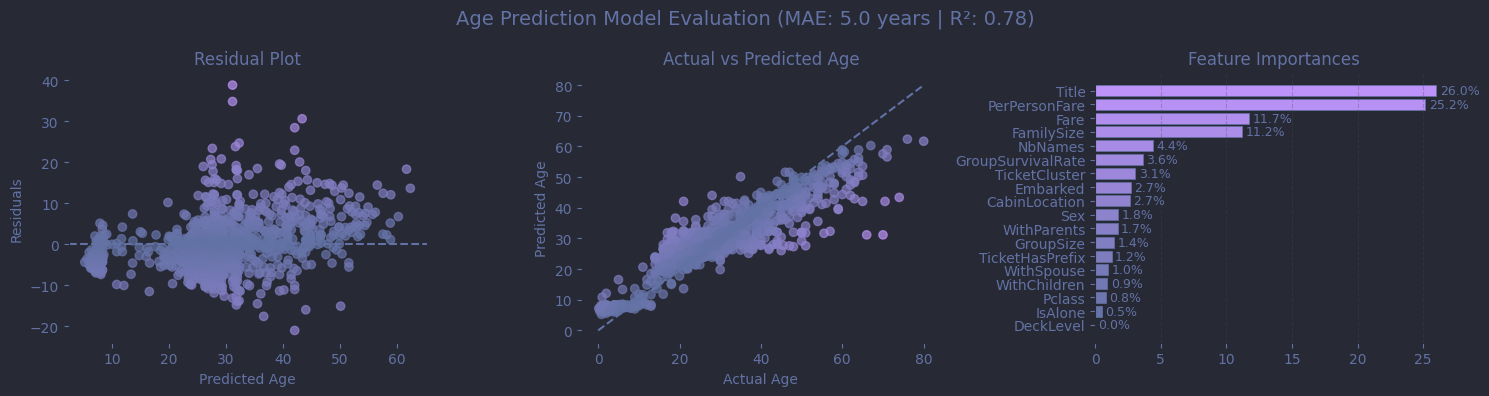

In [31]:
# Visualisation
train_predictions = age_model.predict(age_train)
residuals = y_age - train_predictions
mae = mean_absolute_error(y_age, train_predictions)
r2 = r2_score(y_age, train_predictions)

importance = age_model.feature_importance(importance_type='gain')
importance = np.array(importance) / sum(importance) * 100
feature_names = age_model.feature_name()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

residuals_abs = np.abs(residuals)
colors_residual = sequential_cmap(residuals_abs / max(residuals_abs))
sc1 = ax1.scatter(
    train_predictions, 
    residuals, 
    alpha=0.7, 
    c=residuals_abs,
    cmap=sequential_cmap
)
ax1.axhline(y=0, color=COL_Comment, linestyle='--')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted Age')
ax1.set_ylabel('Residuals')

distance = np.abs(y_age - train_predictions)
colors_error = sequential_cmap(distance / max(distance))
sc2 = ax2.scatter(
    y_age, 
    train_predictions, 
    alpha=0.7, 
    c=distance,
    cmap=sequential_cmap
)
ax2.plot([0, 80], [0, 80], color=COL_Comment, linestyle='--')
ax2.set_title('Actual vs Predicted Age')
ax2.set_xlabel('Actual Age')
ax2.set_ylabel('Predicted Age')

bars = ax3.barh(
    importance_df['Feature'],
    importance_df['Importance'],
    color=sequential_cmap(np.linspace(0, 1, len(importance_df))),
    edgecolor=COL_Comment,
    linewidth=0.5
)
ax3.grid(axis='x', linestyle='--', alpha=0.3)
ax3.set_title('Feature Importances')

for bar in bars:
    width = bar.get_width()
    ax3.text(
        width + max(importance)*0.01, 
        bar.get_y() + bar.get_height()/2, 
        f'{width:.1f}%',
        ha='left', 
        va='center',
        fontsize=9
    )

fig.suptitle(f'Age Prediction Model Evaluation (MAE: {mae:.1f} years | R²: {r2:.2f})', fontsize=14)
fig.tight_layout()
fig.savefig('age_model_results.png')
plt.show()

In [32]:
df[categorical_features + numeric_features]

,Pclass,Sex,Embarked,Title,IsAlone,WithSpouse,WithChildren,WithParents,DeckLevel,CabinLocation,TicketHasPrefix,IsChild,NbNames,FamilySize,TicketCluster,PerPersonFare,GroupSurvivalRate,Age
0,3,male,S,Mr,False,True,False,False,NaN,NaN,True,False,3,2,3,7.25,0.383838,22.000000
1,1,female,C,Mrs,False,True,False,False,C,Midship,True,False,6,2,3,35.64165,0.383838,38.000000
2,3,female,S,Miss,True,False,False,False,NaN,NaN,True,False,2,1,2,7.925,0.383838,26.000000
3,1,female,S,Mrs,False,True,False,False,C,Aft,False,False,6,2,4,26.55,0.191919,35.000000
4,3,male,S,Mr,True,False,False,False,NaN,NaN,False,False,3,1,1,8.05,0.383838,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,male,S,Mr,True,False,False,False,NaN,NaN,True,False,2,1,0,8.05,0.383838,32.517529
1305,1,female,C,Noble,True,False,False,False,C,Aft,True,False,4,1,3,36.3,0.461279,39.000000
1306,3,male,S,Mr,True,False,False,False,NaN,NaN,True,False,3,1,2,7.25,0.383838,38.500000
1307,3,male,S,Mr,True,False,False,False,NaN,NaN,False,False,2,1,1,8.05,0.383838,28.360047


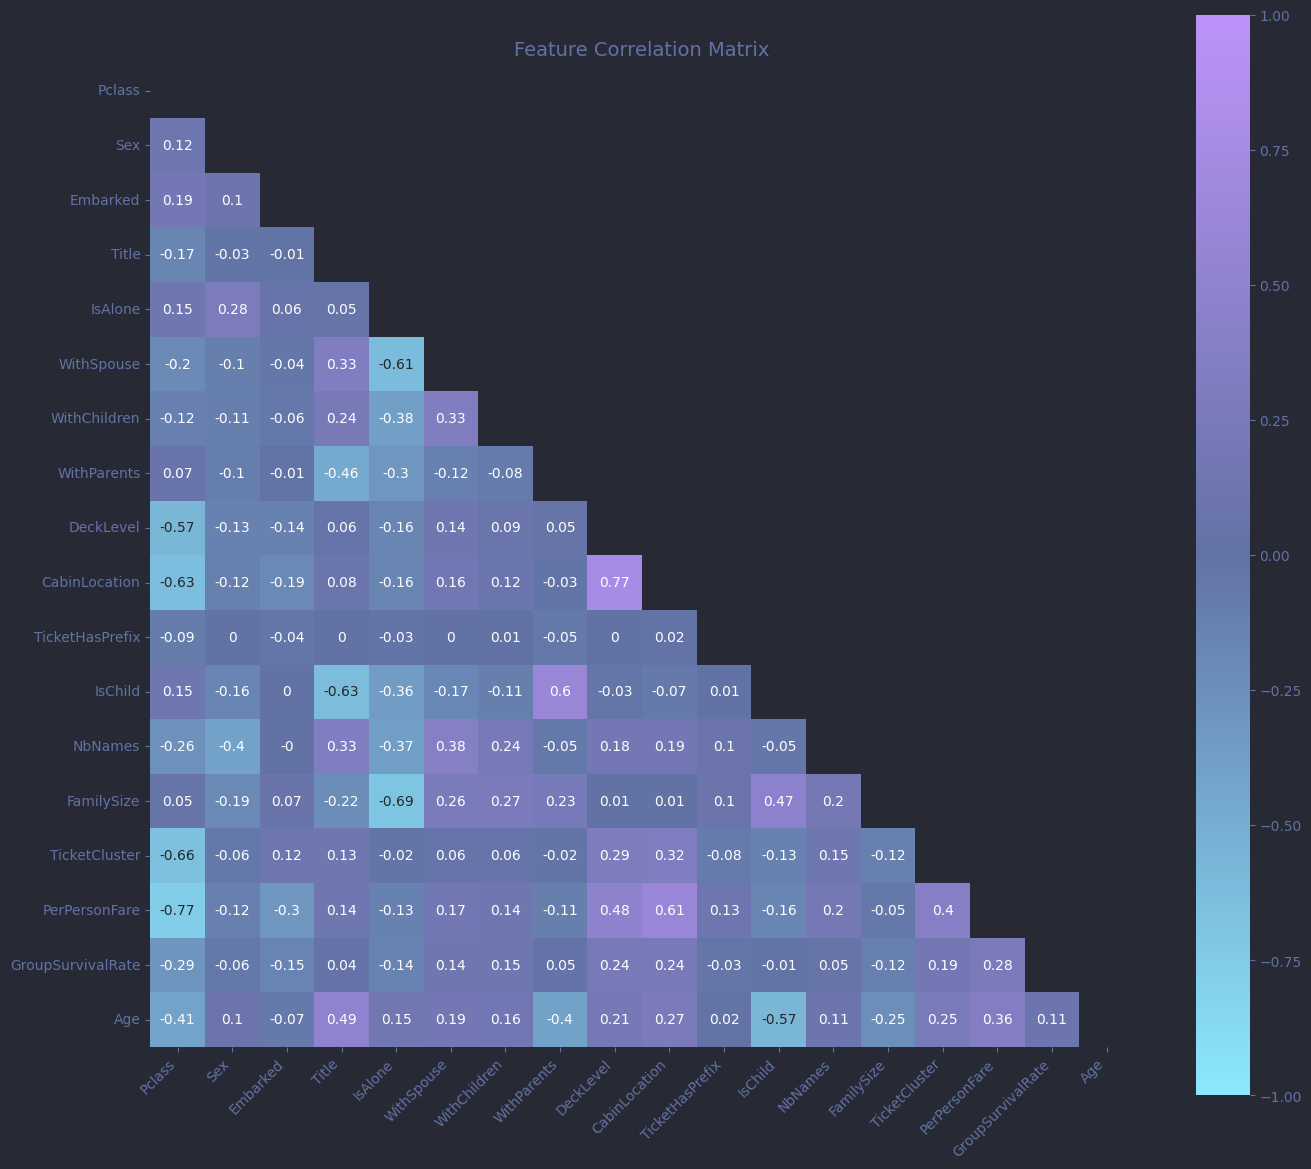

In [33]:
df_sub = df[categorical_features + numeric_features].copy()
for col in categorical_features:
    df_sub[col] = df_sub[col].astype('category').cat.codes

result = associations(
    df_sub,
    nom_nom_assoc='cramer',
    num_num_assoc='pearson',
    plot=False,
)
corr_matrix = result['corr']
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    corr_matrix,
    cmap=diverging_cmap,
    vmin=-1, vmax=1,
    square=True,
    mask = mask,
    annot=corr_matrix.round(2)
)
plt.title("Feature Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Preparation

In [34]:
# cleanup
df_train = df[categorical_features + numeric_features + ['Survived', 'PassengerId']].copy()
df_train[categorical_features] = df_train[categorical_features].astype('category')

train_mask = df_train['Survived'].notna()
test_mask = df_train['Survived'].isna()

test_ids = df_train.loc[test_mask, 'PassengerId']

X_train = df_train.loc[train_mask].drop(columns=['Survived', 'PassengerId'])
y_train = df_train.loc[train_mask, 'Survived']
X_test = df_train.loc[test_mask].drop(columns=['Survived', 'PassengerId'])

# Hyperparameters Tuning

Iter 01 -  3.8s/   4s | Loss: 0.37281 v | Best: 0.37281 | Params: num:64 min:47 col:0.111 iter:1113
Iter 02 -  2.8s/   7s | Loss: 0.37192 v | Best: 0.37192 | Params: num:64 min:19 col:0.323 iter:323
Iter 03 -  1.8s/   8s | Loss: 0.37842 - | Best: 0.37192 | Params: num:35 min:37 col:0.749 iter:395
Iter 04 -  2.4s/  11s | Loss: 0.37528 - | Best: 0.37192 | Params: num:57 min:23 col:0.424 iter:344
Iter 05 -  2.4s/  13s | Loss: 0.37615 - | Best: 0.37192 | Params: num:37 min:19 col:0.432 iter:314
Iter 06 -  2.0s/  15s | Loss: 0.37012 v | Best: 0.37012 | Params: num:60 min:28 col:0.350 iter:388
Iter 07 -  1.7s/  17s | Loss: 0.37414 - | Best: 0.37012 | Params: num:61 min:41 col:0.576 iter:421
Iter 08 -  3.0s/  20s | Loss: 0.37353 - | Best: 0.37012 | Params: num:55 min:14 col:0.419 iter:298
Iter 09 -  1.6s/  21s | Loss: 0.37450 - | Best: 0.37012 | Params: num:58 min:43 col:0.665 iter:434
Iter 10 -  2.5s/  24s | Loss: 0.37572 - | Best: 0.37012 | Params: num:29 min:12 col:0.540 iter:310
Iter 11 -

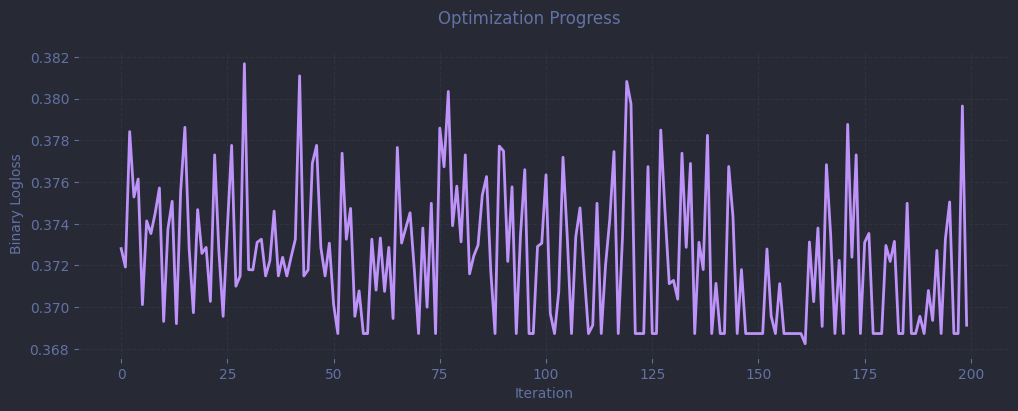

In [35]:
class LoggerCallback:
    def __init__(self):
        self.start_time = time.time()
        self.last_iter_time = self.start_time
        self.best_loss = float('inf')
        self.iteration = 0
        
    def __call__(self, res):
        current_time = time.time()
        elapsed_last = current_time - self.last_iter_time
        elapsed_total = current_time - self.start_time
        self.last_iter_time = current_time
        self.iteration += 1
        
        current_loss = res.func_vals[-1]
        improvement_sign = "v" if current_loss < self.best_loss else "-"
        if current_loss < self.best_loss:
            self.best_loss = current_loss

        last_time_str = f"{elapsed_last:4.1f}s".replace(' ', ' ')
        total_time_str = f"{elapsed_total:4.0f}s".replace(' ', ' ')
        
        param_str = " ".join([
            f"{name[:3]}:{value:>1.3f}" if isinstance(value, float) 
            else f"{name[:3]}:{value:>2}"
            for name, value in zip(search_param_names, res.x_iters[-1])
        ])
        
        print(
            f"Iter {self.iteration:02d} "
            f"- {last_time_str}/{total_time_str} "
            f"| Loss: {current_loss:.5f} {improvement_sign} "
            f"| Best: {self.best_loss:.5f} "
            f"| Params: {param_str}"
            f" iter:{nb_iters[tuple(res.x_iters[-1])]}"
        )

def train_evaluate(search_param_list):
    search_params = {k: v for k, v in zip(search_param_names, search_param_list)}
    cv_results = lgb.cv(
        params = fixed_params | search_params | {'num_iterations' : 50000, 'early_stopping_rounds' : 50},
        train_set = lgb.Dataset(X_train, label=y_train),
        nfold = 10,
        stratified = True,
        shuffle = True,
        return_cvbooster = True,
        seed = SEED
    )    
    nb_iters[tuple(search_param_list)] = len(cv_results['valid binary_logloss-mean'])
    return cv_results['valid binary_logloss-mean'][-1]

search_param_names = ['num_leaves', 'min_data_in_leaf', 'colsample_bynode']
fixed_params = {
    'metric' : ['binary_logloss'], 
    'objective' : 'binary',
    'boosting' : 'gbrt',
    'learning_rate' : 0.01,
    'is_unbalanced' : True,
    'verbose' : -1,
    'seed' : SEED
}
nb_iters = {}

result = gp_minimize(
    train_evaluate,
    [
        Integer(16, 64),        # num_leaves
        Integer(10, 50),        # min_data_in_leaf
        Real(0.01, 0.8),         # colsample_bynode
    ],
    callback=[LoggerCallback()],
    n_initial_points=20,
    n_calls=200,
    n_jobs=-1,
    random_state=SEED
)

best_params = {k: v for k, v in zip(search_param_names, result.x)}
best_params['num_iterations'] = nb_iters[tuple(result.x)]

print(f'Total evaluations: {len(result.func_vals)}')
print(f'Lowest Logloss: {result.fun}')
print('Best parameters:')
for k, v in best_params.items():
    print(f'{k} : {v}')

plt.figure(figsize=(12, 4))
sns.lineplot(data=result.func_vals, linewidth=2, color=COL_Purple)
plt.suptitle('Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Binary Logloss')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

<Figure size 640x480 with 0 Axes>

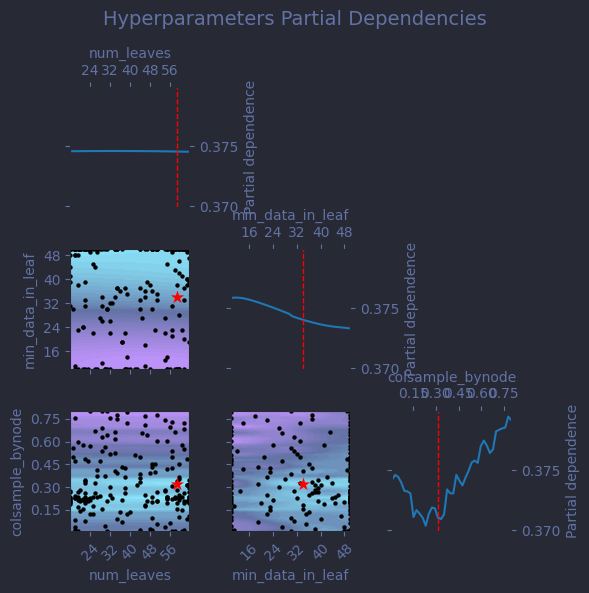

In [36]:
plt.figure()
plot_objective(result, levels=40, dimensions=search_param_names, cmap=diverging_cmap)
plt.suptitle('Hyperparameters Partial Dependencies', fontsize=14)
plt.tight_layout()
plt.show()

# Threshold Optimisation

In [37]:
nfolds = 5
folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=SEED)
oof_pred = np.zeros(len(X_train))

for train_idx, val_idx in tqdm(folds.split(X_train, y_train), total=nfolds):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model = lgb.train(
        fixed_params | best_params,
        lgb.Dataset(X_tr, label=y_tr)
    )
    oof_pred[val_idx] = model.predict(X_val)

print('Standard threshold: 0.5')
print(classification_report(y_train, (oof_pred >= 0.5).astype(int)))

best_thresh = 0.5
precisions, recalls, thresholds = precision_recall_curve(y_train, oof_pred)
valid_indices = np.where(recalls[:-1] >= 0.6)[0]
if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax(precisions[valid_indices])]
    best_thresh = thresholds[best_idx] 
    print(f"Optimal threshold: {best_thresh:.4f}")
else:
    print("No threshold meets recall constraint. Using 0.5")
print(classification_report(y_train, (oof_pred >= best_thresh).astype(int)))

100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]

Standard threshold: 0.5
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88       549
         1.0       0.84      0.72      0.77       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

Optimal threshold: 0.7301
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       549
         1.0       0.94      0.61      0.74       342

    accuracy                           0.84       891
   macro avg       0.87      0.79      0.81       891
weighted avg       0.85      0.84      0.83       891



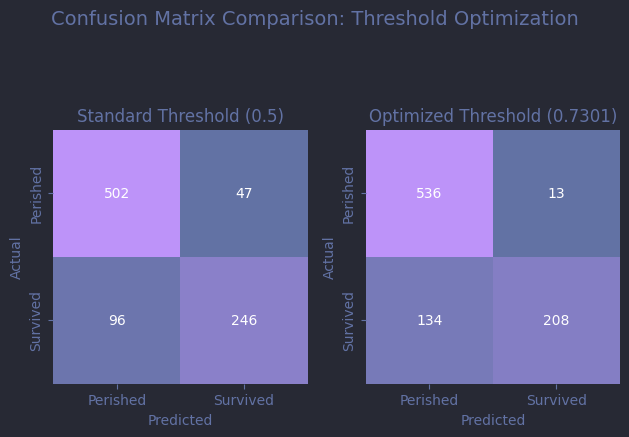

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)

y_pred_standard = (oof_pred >= 0.5).astype(int)
cm_standard = confusion_matrix(y_train, y_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap=sequential_cmap, cbar=False, square = True, ax=ax1)
ax1.set_title(f"Standard Threshold (0.5)")
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.xaxis.set_ticklabels(['Perished', 'Survived'])
ax1.yaxis.set_ticklabels(['Perished', 'Survived'])

y_pred_optimized = (oof_pred >= best_thresh).astype(int)
cm_optimized = confusion_matrix(y_train, y_pred_optimized)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap=sequential_cmap, cbar=False, square = True, ax=ax2)
ax2.set_title(f"Optimized Threshold ({best_thresh:.4f})")
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.xaxis.set_ticklabels(['Perished', 'Survived'])
ax2.yaxis.set_ticklabels(['Perished', 'Survived'])

plt.suptitle('Confusion Matrix Comparison: Threshold Optimization', fontsize=14)
plt.tight_layout()
plt.show()

# Final Training and Export

In [39]:
model = lgb.train(
    fixed_params | best_params,
    lgb.Dataset(X_train, label=y_train)
)

y_pred = model.predict(X_test)

df_pred = pd.DataFrame({
    'PassengerId': test_ids.reset_index(drop=True),
    'Survived': (y_pred >= best_thresh).astype(int)
})

df_pred.to_csv(f'predictions_v6-{SEED}.csv', index=False)

# Analysis

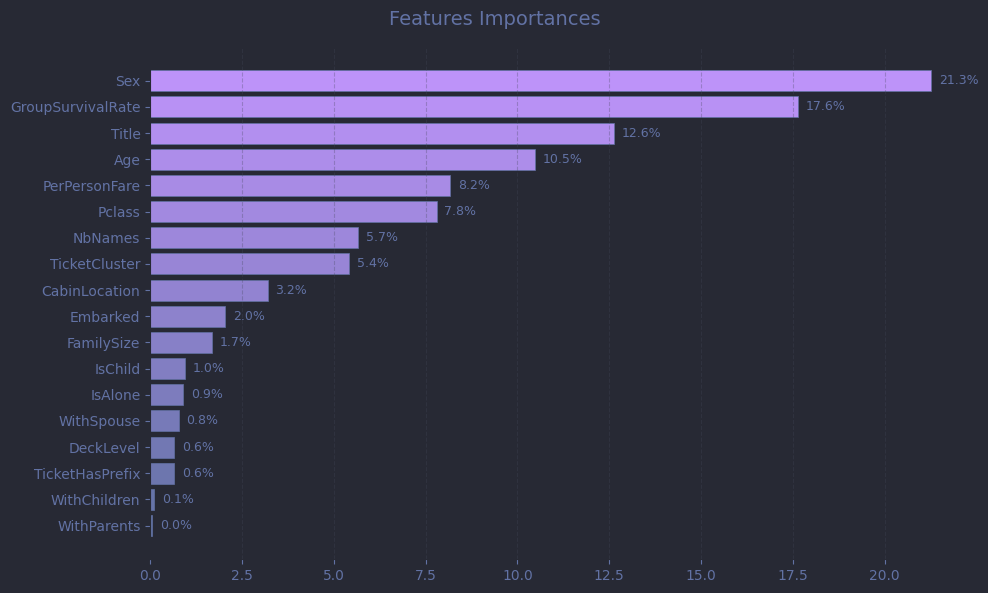

In [46]:
# Feature Importances 
importance = model.feature_importance(importance_type='gain')
importance = np.array(importance) / sum(importance) * 100
feature_names = model.feature_name()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=True)


plt.figure(figsize=(10, 6))

bars = plt.barh(
    importance_df['Feature'],
    importance_df['Importance'],
    color=sequential_cmap(np.linspace(0, 1, len(importance_df))),
    edgecolor=COL_Comment,
    linewidth=0.5
)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(importance)*0.01, 
        bar.get_y() + bar.get_height()/2, 
        f'{width:.1f}%',
        ha='left', 
        va='center',
        fontsize=9
    )

plt.suptitle('Features Importances', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


Mapping for Pclass:
  1 → 0
  2 → 1
  3 → 2

Mapping for Sex:
  female → 0
  male → 1

Mapping for Embarked:
  C → 0
  Q → 1
  S → 2

Mapping for Title:
  Master → 0
  Military → 1
  Miss → 2
  Mr → 3
  Mrs → 4
  Noble → 5
  Professional → 6

Mapping for IsAlone:
  False → 0
  True → 1

Mapping for WithSpouse:
  False → 0
  True → 1

Mapping for WithChildren:
  False → 0
  True → 1

Mapping for WithParents:
  False → 0
  True → 1

Mapping for DeckLevel:
  A → 0
  B → 1
  C → 2
  D → 3
  E → 4
  Lower → 5

Mapping for CabinLocation:
  Forward → 0
  Midship → 1
  Aft → 2

Mapping for TicketHasPrefix:
  False → 0
  True → 1

Mapping for IsChild:
  False → 0
  True → 1


/home/greyecho/Documents/jupyter/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


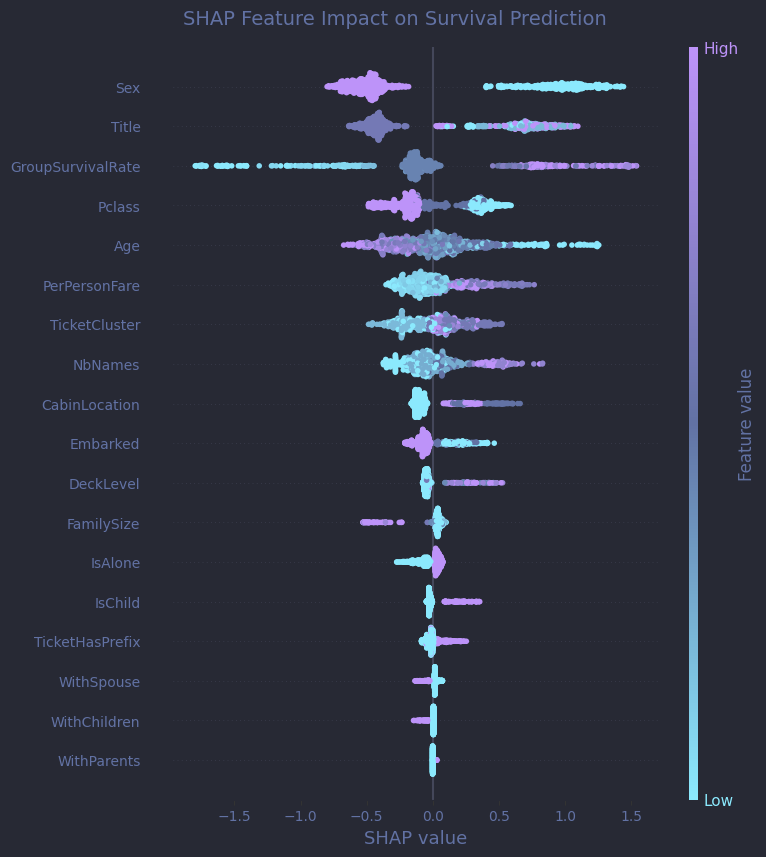

In [47]:
# Beeswarm plot
X_train_encoded = X_train.copy()
for col in categorical_features:
    print(f"\nMapping for {col}:")
    categories = X_train_encoded[col].cat.categories
    mapping = {category: code for code, category in enumerate(categories)}
    for category, code in mapping.items():
        print(f"  {category} → {code}")
        
    X_train_encoded[col] = X_train_encoded[col].cat.codes

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

plt.figure()
shap.summary_plot(
    shap_values,
    X_train_encoded,
    plot_type="dot",
    show=False,
    cmap=diverging_cmap,
)

ax = plt.gca()
ax.set_xlabel("SHAP value")

for line in ax.get_lines():
    line.set_color(COL_Selection)
    
for label in ax.get_xticklabels():
    label.set_color(COL_Comment)
    label.set_fontsize(10)

for label in ax.get_yticklabels():
    label.set_color(COL_Comment)
    label.set_fontsize(10)

cb = plt.gcf().axes[-1]
tick_labels = cb.get_yticklabels()
tick_labels[0].set_color(COL_Cyan)
tick_labels[1].set_color(COL_Purple)

plt.suptitle("SHAP Feature Impact on Survival Prediction", fontsize=14)
plt.tight_layout()
plt.savefig('shap_beeswarm.png')
plt.show()

Braund, Mr. Owen Harris - Predicted : 0.08201736025116292 | Actual : False
- Male, 22 year-old 3rd class passenger
- Good exemple


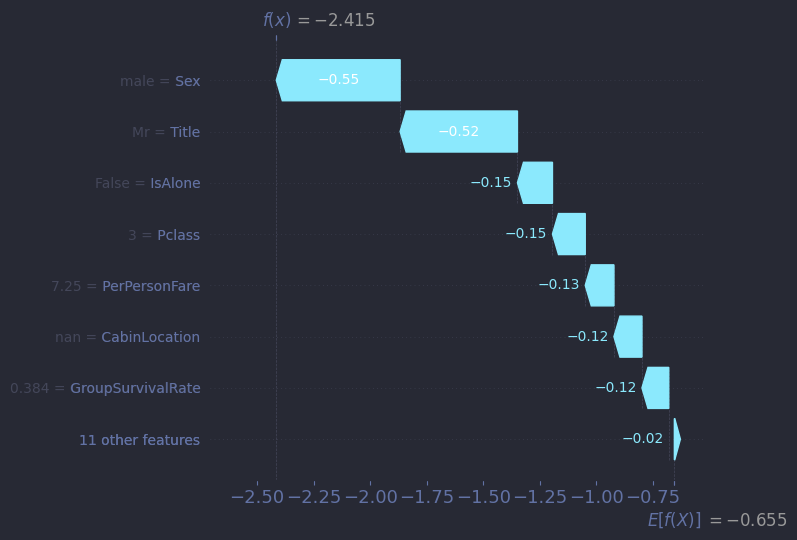

Thomas, Master. Assad Alexander - Predicted : 0.7681728511090679 | Actual : True
- 9-month-old Syrian infant traveling 3rd class with mother
- Survived against bad odds (3rd class male)
- Mother died, father survived


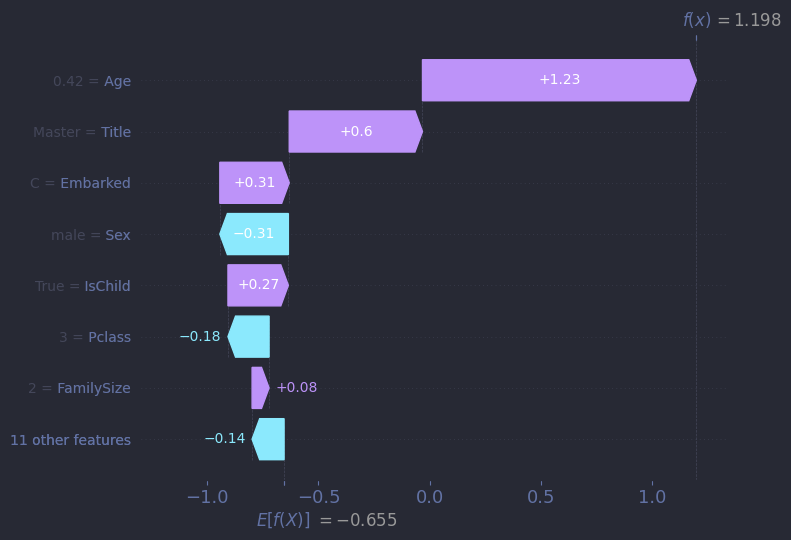

Isham, Miss. Ann Elizabeth - Predicted : 0.8829297558645154 | Actual : False
- 50-year-old unmarried 1st class woman
- Only 1st class female casualty without family ties
- Legend claims she refused to leave without her Great Dane


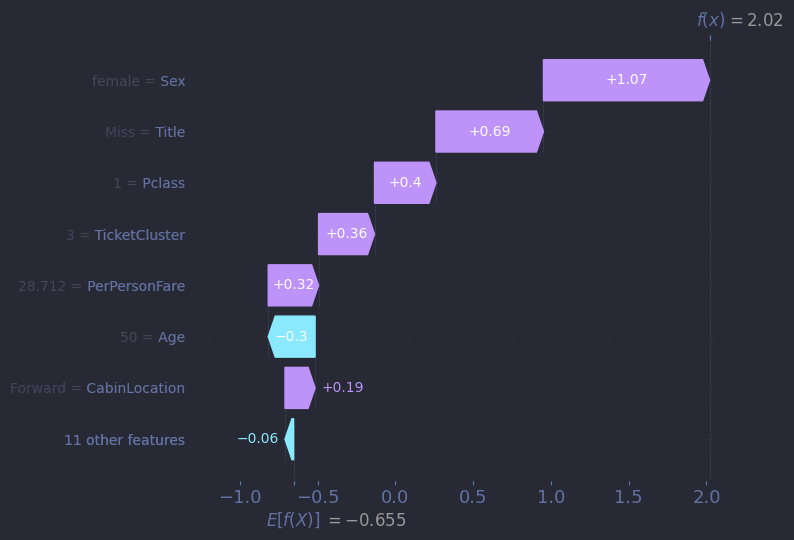

Cardeza, Mr. Thomas Drake Martinez - Predicted : 0.6079971176004443 | Actual : True
- Paid highest fare (£512/$65k today) for private promenade deck
- Traveled with 14 trunks - most luggage onboard
- Survived with mother and valet


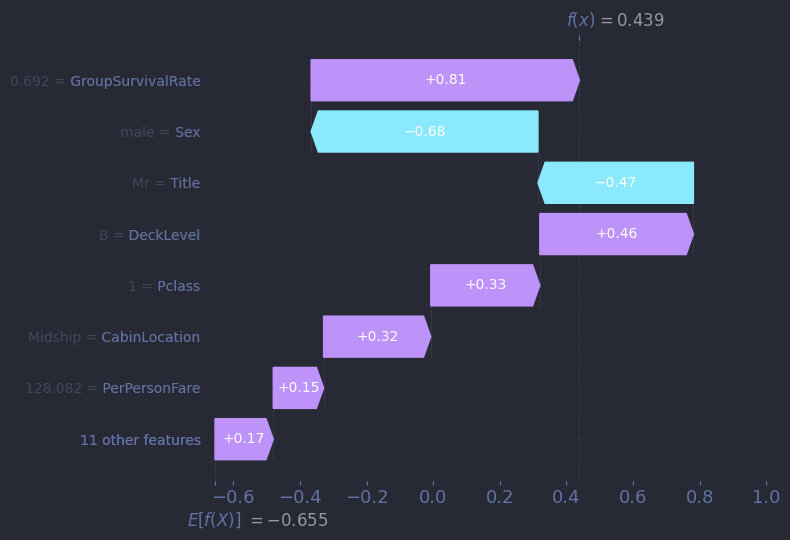

Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson) - Predicted : 0.7175970002610365 | Actual : True
- Saved 5 children but lost husband, - 3rd class big family (8 members, of which only 3 survived)


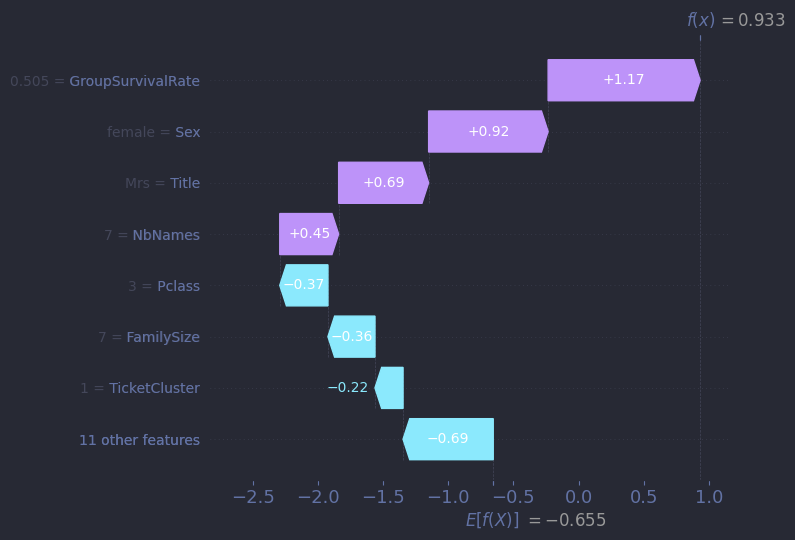

In [49]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_explanation = explainer(X_train)
predictions = model.predict(X_train)

interresting_passenger_idx = [1, 804, 178, 680, 26]
# Thomas, Master. Assad Alexander
# Isham, Miss. Ann Elizabeth
# Cardeza, Mr. Thomas Drake Martinez
# Asplund, Mrs. Carl Oscar (Selma)

Passengers_context = [
    '- Male, 22 year-old 3rd class passenger\n- Good exemple',
    '- 9-month-old Syrian infant traveling 3rd class with mother\n- Survived against bad odds (3rd class male)\n- Mother died, father survived',
    '- 50-year-old unmarried 1st class woman\n- Only 1st class female casualty without family ties\n- Legend claims she refused to leave without her Great Dane',
    '- Paid highest fare (£512/$65k today) for private promenade deck\n- Traveled with 14 trunks - most luggage onboard\n- Survived with mother and valet',
    '- Saved 5 children but lost husband, - 3rd class big family (8 members, of which only 3 survived)'
]

for idx, context in zip(interresting_passenger_idx, Passengers_context):
    passenger_data = df.loc[df['PassengerId'] == idx]
    print(f'{passenger_data['Name'].values[0]} - Predicted : {predictions[idx-1]} | Actual : {passenger_data['Survived'].values[0]}')
    print(context)
    
    fig = plt.gcf()
    ax = plt.gca()
    
    shap.plots.waterfall(
        shap_explanation[idx-1],  # For survival class
        max_display=8,
        show=False
    )
    
    # Customize y_labels
    for label in ax.get_yticklabels():
        if '=' in label.get_text():  # Feature names/values
            label.set_color(COL_Selection)
        else:
            label.set_color(COL_Comment)
        label.set_fontsize(10)
    
    import matplotlib
    default_pos_color = "#ff0051"
    default_neg_color = "#008bfb"
    positive_color = COL_Purple
    negative_color = COL_Cyan
    for fc in fig.get_children():
        for fcc in fc.get_children():
            if (isinstance(fcc, matplotlib.patches.FancyArrow)):
                if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                    fcc.set_color(positive_color)
                elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                    fcc.set_color(negative_color)
            elif (isinstance(fcc, plt.Text)):
                if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                    fcc.set_color(positive_color)
                elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                    fcc.set_color(negative_color)
                fcc.set_fontsize(10)
    
    # Customize lines
    for line in ax.lines:
        line.set_color(COL_Selection)
    
    # Set title
    #plt.suptitle(f"SHAP Waterfall for {passenger_data['Name'].values[0]}", fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_{idx}.png')
    plt.show()

In [43]:
!jupyter nbconvert --to script 'Kaggle - titanic6.ipynb'

[NbConvertApp] Converting notebook Kaggle - titanic6.ipynb to script
[NbConvertApp] Writing 22765 bytes to Kaggle - titanic6.py
